In [15]:
import os
import pandas as pd
import numpy as np
import tweepy
import re
import string
from textblob import TextBlob
import preprocessor as p
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import json
import zipfile
import lzma
from os.path import isfile, join
from random import sample 
import ast
import us
from json.decoder import JSONDecodeError
import seaborn as sns
import geopandas as gpd
from functools import reduce
import warnings
from datetime import datetime
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

directory = os.chdir('../data/raw/processed')

## Time Series

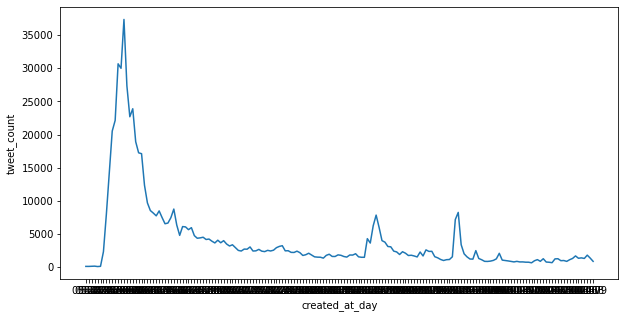

In [18]:
# tweets_gdf = gpd.read_file("tweets_gdf_fs.geojson", driver="GeoJSON")

# tweets_gdf['created_at'] = pd.to_datetime(tweets_gdf['created_at'])
# tweets_gdf['tweet_count'] = 1
# tweets_gdf['created_at_day'] = tweets_gdf['created_at'].dt.strftime('%m-%d')

fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(data = tweets_gdf.groupby('created_at_day').sum().reset_index(), x = 'created_at_day', y = 'tweet_count')

## Tweets vs. Protests

In [21]:
tweets_gdf = gpd.read_file("tweets_gdf_fs.geojson", driver="GeoJSON")
df_p = pd.read_excel("../USA_2020_2021_Feb12.xlsx")

In [34]:
tweets_gdf = tweets_gdf[tweets_gdf['geometry'].isna()==False]

In [23]:
# df_p = pd.read_excel('../USA_2020_2021_Feb12.xlsx')
df_p['protest_count'] = 1
df_p['EVENT_DATE'] = pd.to_datetime(df_p['EVENT_DATE'])
df_p = df_p[(df_p['ASSOC_ACTOR_1'] == "BLM: Black Lives Matter")&(df_p['EVENT_DATE']> "2020-05-25")]

In [24]:
print("In 2020,", len(df_p), "BLM protests took place after George Floyd's death on May 25th")

In 2020, 7866 BLM protests took place after George Floyd's death on May 25th


In [26]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# fig, ax = plt.subplots(figsize=(15,10))
# sns.scatterplot(data=df_p[df_p['LONGITUDE']>-130], x='LONGITUDE', y='LATITUDE', s=4)

### Counties

In [27]:
### next, spatial join number of protests per county, number of tweets per county, color by policy implemented
### scatter plot tweets vs protests
from functools import reduce
# load counties
counties = gpd.read_file("../us_admin/tl_2017_us_county.shp")#cb_2018_us_county_5m
counties_pop = pd.read_excel("../us_admin/PopulationEstimates.xls", skiprows = [0,1], converters={'FIPStxt': str})[["FIPStxt", "POP_ESTIMATE_2019"]].rename(columns={"FIPStxt":"GEOID"})
counties_hhi = pd.read_excel("../us_admin/Unemployment.xls", skiprows = [0,1,2,3],converters={'fips_txt': str})[['fips_txt', 'Median_Household_Income_2019', 'Unemployment_rate_2019']].rename(columns={"fips_txt":"GEOID"})
counties_edu = pd.read_excel("../us_admin/Education.xls", skiprows = [0,1,2,3],converters={'FIPS Code': str})[['FIPS Code', 'Percent of adults with less than a high school diploma, 2015-19']].rename(columns={"FIPS Code":"GEOID"})
counties_pov = pd.read_excel("../us_admin/PovertyEstimates.xls", skiprows = [0,1,2,3],converters={'FIPStxt': str})[['FIPStxt', 'PCTPOVALL_2019']].rename(columns={"FIPStxt":"GEOID"})

counties_vars = [counties_pop, counties_hhi, counties_edu, counties_pov, counties[['GEOID', 'geometry']]]
counties = gpd.GeoDataFrame(reduce(lambda left,right: pd.merge(left,right,on='GEOID'), counties_vars), crs={'init': 'epsg:4269'})
# counties = pd.merge(counties, counties_pop, left_on="GEOID", right_on="FIPStxt")

In [28]:
# convert both protests and tweets to gdfs
gdf_p = gpd.GeoDataFrame(
    df_p, geometry=gpd.points_from_xy(df_p.LONGITUDE, df_p.LATITUDE), crs=counties.crs)

# tweets_gdf = gpd.GeoDataFrame(
#     tweets_df_geo, geometry=gpd.points_from_xy(tweets_df_geo.lng, tweets_df_geo.lat), crs=counties.crs)

In [29]:
# interpolate protests and tweets per county (sum on tweet_count and protest_count)
counties_p = gpd.sjoin(gdf_p, counties, how='right') 
counties_p = counties_p.groupby(['GEOID']).sum().reset_index()[['GEOID', 'protest_count']]

In [36]:
# interpolate protests and tweets per county (sum on tweet_count and protest_count)
tweets_gdf['tweet_count'] = 1
counties_t = gpd.sjoin(tweets_gdf, counties, how='right')
counties_t = counties_t.groupby(['GEOID']).sum().reset_index()[['GEOID', 'tweet_count']]

Exception ignored in: <function PreparedGeometry.__del__ at 0x0000018C39E84950>
Traceback (most recent call last):
  File "C:\Users\Leonardo\Anaconda3\lib\site-packages\shapely\prepared.py", line 34, in __del__
    if self.__geom__ is not None:
AttributeError: 'PreparedGeometry' object has no attribute '__geom__'


In [37]:
# presidential elections
counties_e = pd.read_csv("https://raw.githubusercontent.com/tonmcg/US_County_Level_Election_Results_08-20/master/2020_US_County_Level_Presidential_Results.csv", converters={'county_fips': str})
counties_e_2016 = pd.read_csv("https://raw.githubusercontent.com/tonmcg/US_County_Level_Election_Results_08-20/master/2016_US_County_Level_Presidential_Results.csv", converters={'combined_fips': str}).drop("Unnamed: 0", axis=1)
counties_e_2016['combined_fips'][counties_e_2016['combined_fips'].apply(lambda x: len(str(x))==4)] = "0" + counties_e_2016['combined_fips'][counties_e_2016['combined_fips'].apply(lambda x: len(str(x))==4)]

counties_e = pd.merge(counties_e, counties_e_2016, left_on = "county_fips", right_on="combined_fips")

counties_e.columns = ['state_name', 'GEOID', 'NAMELSAD', 'votes_gop_2020', 'votes_dem_2020', 
                     'total_votes_2020', 'diff_2020', 'per_gop_2020', 'per_dem_2020', 'per_point_diff_2020',
                     'votes_dem_2016', 'votes_gop_2016', 'total_votes_2016', 'per_dem_2016', 'per_gop_2016',
                     'diff_2016', 'per_point_diff_2016', 'state_abbr', 'county_name_2016', 'combined_fips']

# counties_e["per_point_diff_abs_2020"] = np.abs(counties_e["per_point_diff_2020"])
# counties_e["per_point_diff_abs_2016"] = np.abs(counties_e["per_point_diff_2016"])

In [38]:
dfs = [counties_t, counties_p, counties_e, counties[['GEOID', 'POP_ESTIMATE_2019', 
                                                     'Median_Household_Income_2019', 
                                                     'Unemployment_rate_2019', 
                                                     'Percent of adults with less than a high school diploma, 2015-19',
                                                     'PCTPOVALL_2019','geometry']]]

counties_tp = gpd.GeoDataFrame(reduce(lambda left,right: pd.merge(left,right,on='GEOID'), dfs))

counties_tp['votes_100k_2016'] = (counties_tp['total_votes_2016']/counties_tp['POP_ESTIMATE_2019'])*100000
counties_tp['votes_100k_2020'] = (counties_tp['total_votes_2020']/counties_tp['POP_ESTIMATE_2019'])*100000
counties_tp['votes_100k_change'] = (counties_tp['votes_100k_2020'] - counties_tp['votes_100k_2016'])/counties_tp['votes_100k_2016']

In [39]:
counties_tp['tweet_count_100k'] = (counties_tp['tweet_count']/counties_tp['POP_ESTIMATE_2019'])*100000
counties_tp['protest_count_100k'] = (counties_tp['protest_count']/counties_tp['POP_ESTIMATE_2019'])*100000

counties_tp['party_2016'] = ""
counties_tp['party_2020'] = ""

counties_tp['party_2016'][counties_tp['per_dem_2016']<0.5] = "Red"
counties_tp['party_2016'][counties_tp['per_dem_2016']>0.5] = "Blue"

counties_tp['party_2020'][counties_tp['per_dem_2020']<0.5] = "Red"
counties_tp['party_2020'][counties_tp['per_dem_2020']>0.5] = "Blue"

Text(0.5, 1.0, 'Number of protests vs. number of Tweets per U.S. county')

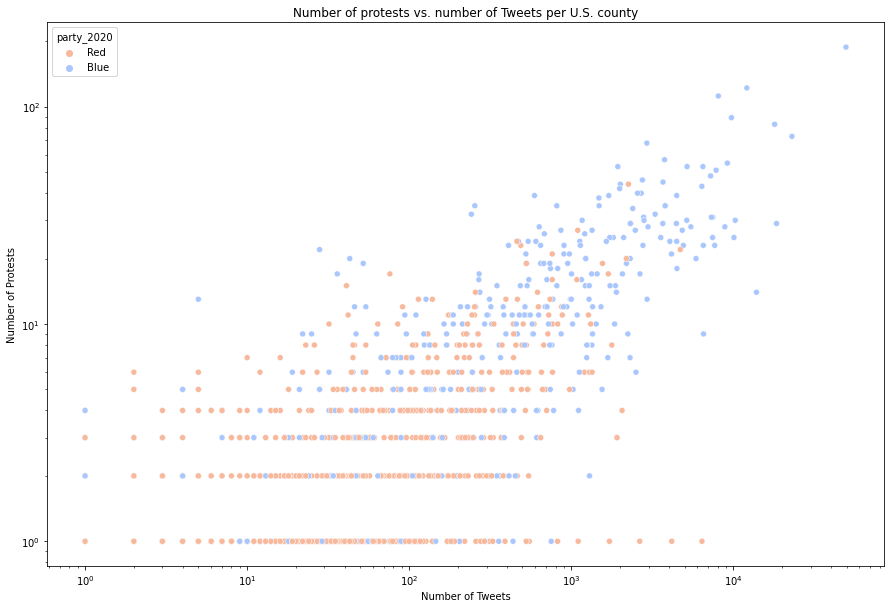

In [40]:
fig, ax = plt.subplots(figsize=(15,10)) ##[counties_tp['tweet_count']<100]
sns.scatterplot(data=counties_tp[(counties_tp['tweet_count']!=0)&(counties_tp['protest_count']!=0)], 
                x='tweet_count', y='protest_count', hue = "party_2020", palette = "coolwarm_r") 

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylabel("Number of Protests")
ax.set_xlabel("Number of Tweets")
plt.title("Number of protests vs. number of Tweets per U.S. county")

Text(0.5, 1.0, 'Number of protests vs. number of Tweets per U.S. county')

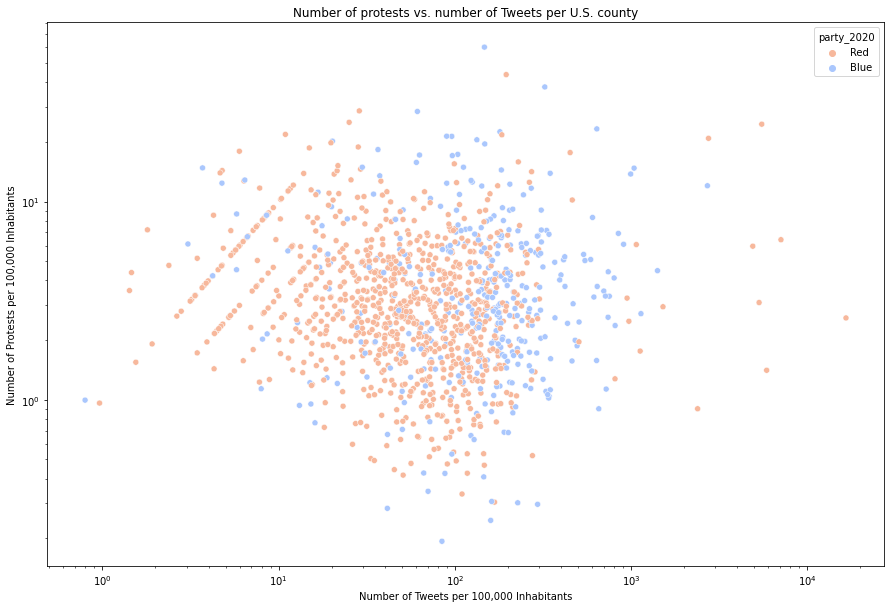

In [43]:
fig, ax = plt.subplots(figsize=(15,10)) ##[counties_tp['tweet_count']<100]
sns.scatterplot(data=counties_tp[(counties_tp['tweet_count_100k']!=0)&(counties_tp['protest_count_100k']!=0)], 
                x='tweet_count_100k', y='protest_count_100k', hue = "party_2020", palette = "coolwarm_r") 

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylabel("Number of Protests per 100,000 Inhabitants")
ax.set_xlabel("Number of Tweets per 100,000 Inhabitants")
plt.title("Number of protests vs. number of Tweets per U.S. county")

Text(0.5, 1.0, 'Tweeting Density vs. % Democratic Votes per U.S. county')

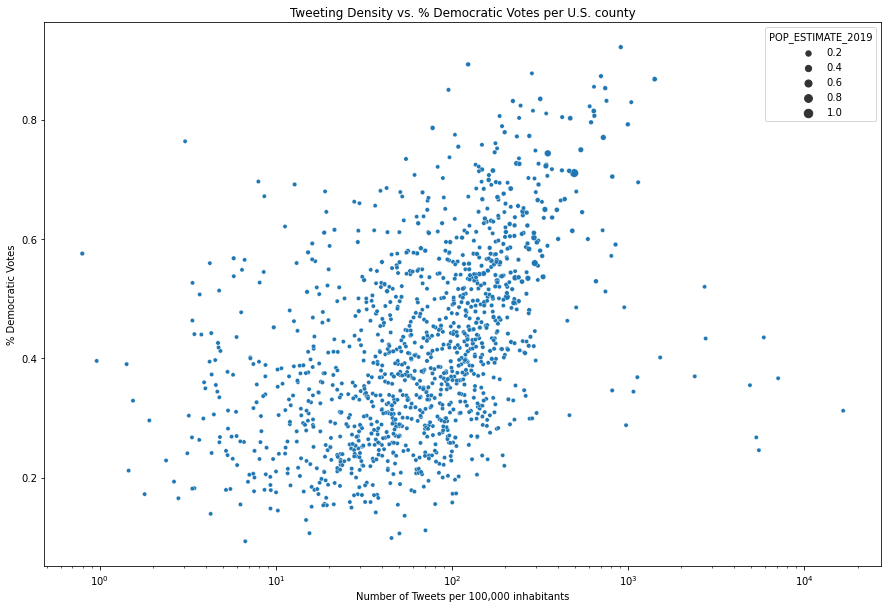

In [44]:
fig, ax = plt.subplots(figsize=(15,10)) ##[counties_tp['tweet_count']<100]
sns.scatterplot(data=counties_tp[(counties_tp['tweet_count_100k']!=0)&(counties_tp['protest_count_100k']!=0)], x='tweet_count_100k', 
                y='per_dem_2020', #hue = "party", palette = "coolwarm_r", 
                size = "POP_ESTIMATE_2019")

ax.set_xscale('log')
# ax.set_yscale('log')

ax.set_ylabel("% Democratic Votes")
ax.set_xlabel("Number of Tweets per 100,000 inhabitants")
plt.title("Tweeting Density vs. % Democratic Votes per U.S. county")

In [145]:
# fig, ax = plt.subplots(figsize=(15,10)) ##[counties_tp['tweet_count']<100]
# sns.scatterplot(data=counties_tp[(counties_tp['tweet_count_100k']>0)&(counties_tp['votes_100k_change']>0)]
#                 , x='tweet_count_100k', 
#                 y='votes_100k_change', #hue = "party", palette = "coolwarm_r", 
#                 size = "POP_ESTIMATE_2019")

# ax.set_xscale('log')
# ax.set_yscale('log')

# ax.set_ylabel("% Change in voting population")
# ax.set_xlabel("Number of Tweets per 100,000 inhabitants")
# plt.title("Tweeting Density vs. % Change in voting population per U.S. county")

In [147]:
# counties_tp

Text(0.5, 1.0, 'Tweeting Density vs. % Change in voting population per U.S. county')

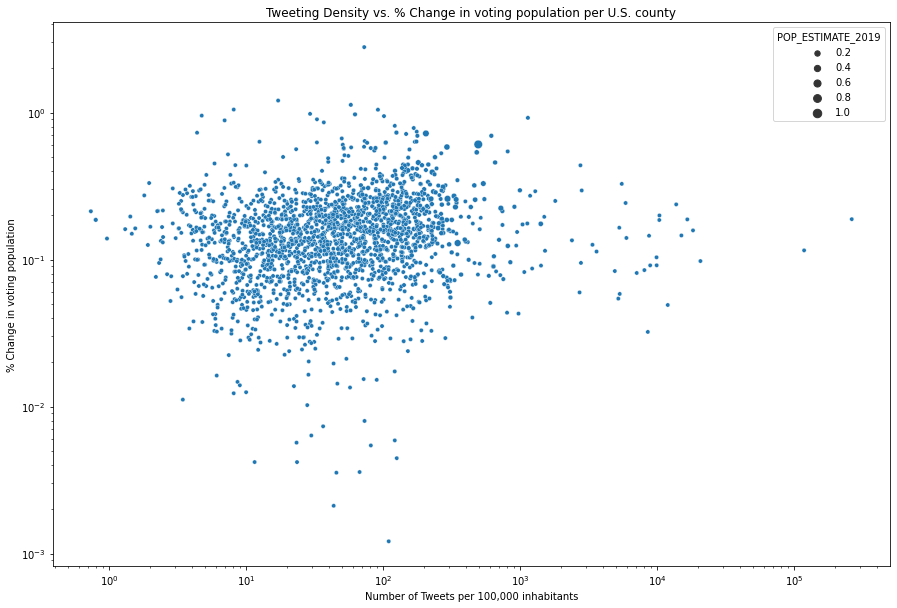

In [50]:
fig, ax = plt.subplots(figsize=(15,10)) ##[counties_tp['tweet_count']<100]
sns.scatterplot(data=counties_tp[(counties_tp['tweet_count_100k']>0)&(counties_tp['votes_100k_change']>0)]
                , x='tweet_count_100k', 
                y='votes_100k_change', #hue = "party", palette = "coolwarm_r", 
                size = "POP_ESTIMATE_2019")

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylabel("% Change in voting population")
ax.set_xlabel("Number of Tweets per 100,000 inhabitants")
plt.title("Tweeting Density vs. % Change in voting population per U.S. county")

Text(0.5, 1.0, 'Protest Density vs. % Change in voting population per U.S. county')

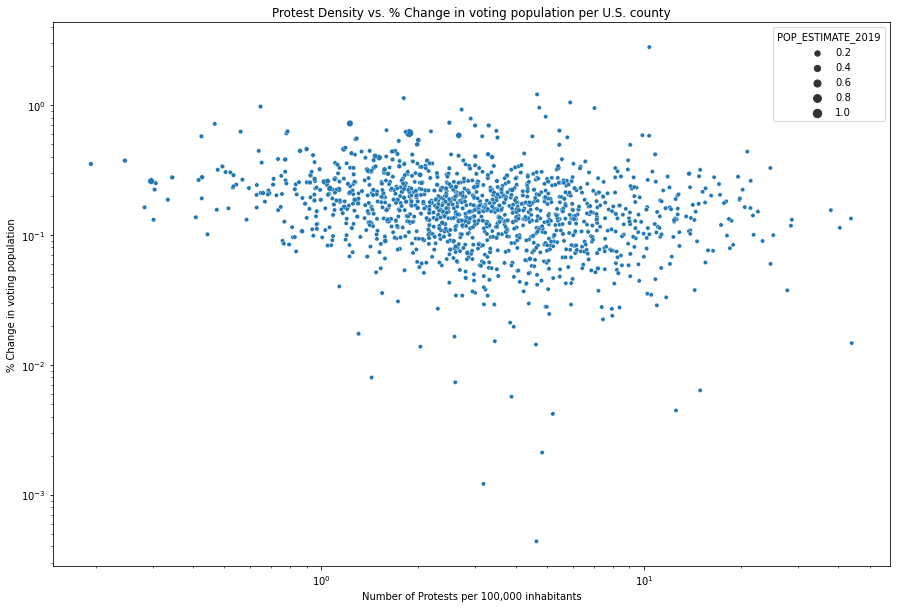

In [46]:
fig, ax = plt.subplots(figsize=(15,10)) ##[counties_tp['tweet_count']<100]
sns.scatterplot(data=counties_tp[(counties_tp['protest_count_100k']>0)&(counties_tp['votes_100k_change']>0)]
                , x='protest_count_100k', 
                y='votes_100k_change', #hue = "party", palette = "coolwarm_r", 
                size = "POP_ESTIMATE_2019")

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylabel("% Change in voting population")
ax.set_xlabel("Number of Protests per 100,000 inhabitants")
plt.title("Protest Density vs. % Change in voting population per U.S. county")

Text(0.5, 1.0, 'Tweeting Density vs. % Democratic Votes per U.S. county')

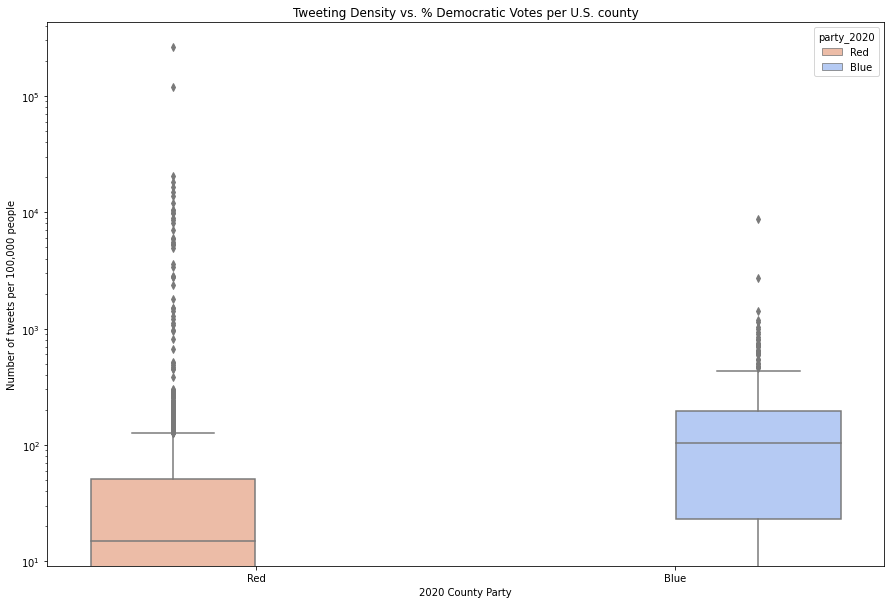

In [52]:
fig, ax = plt.subplots(figsize=(15,10)) ##[counties_tp['tweet_count']<100]
sns.boxplot(data=counties_tp, y='tweet_count_100k', 
                x='party_2020', hue = "party_2020", palette = "coolwarm_r")
# ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylabel("Number of tweets per 100,000 people")
ax.set_xlabel("2020 County Party")
plt.title("Tweeting Density vs. % Democratic Votes per U.S. county")

Text(0.5, 1.0, 'Tweeting Density vs. Income per U.S. county')

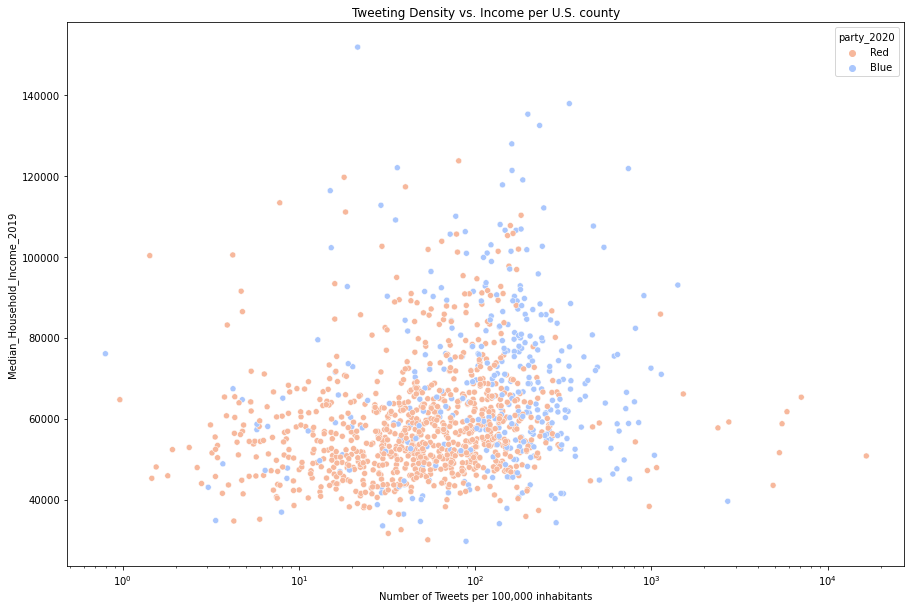

In [55]:
fig, ax = plt.subplots(figsize=(15,10)) ##[counties_tp['tweet_count']<100]
sns.scatterplot(data=counties_tp[(counties_tp['tweet_count_100k']!=0)&(counties_tp['protest_count_100k']!=0)], x='tweet_count_100k', y='Median_Household_Income_2019',
               hue = "party_2020", palette = "coolwarm_r")
ax.set_xscale('log')
# ax.set_yscale('log')

ax.set_ylabel("Median_Household_Income_2019")
ax.set_xlabel("Number of Tweets per 100,000 inhabitants")
plt.title("Tweeting Density vs. Income per U.S. county")

Text(0.5, 1.0, 'Tweeting Density vs. Unemployment per U.S. county')

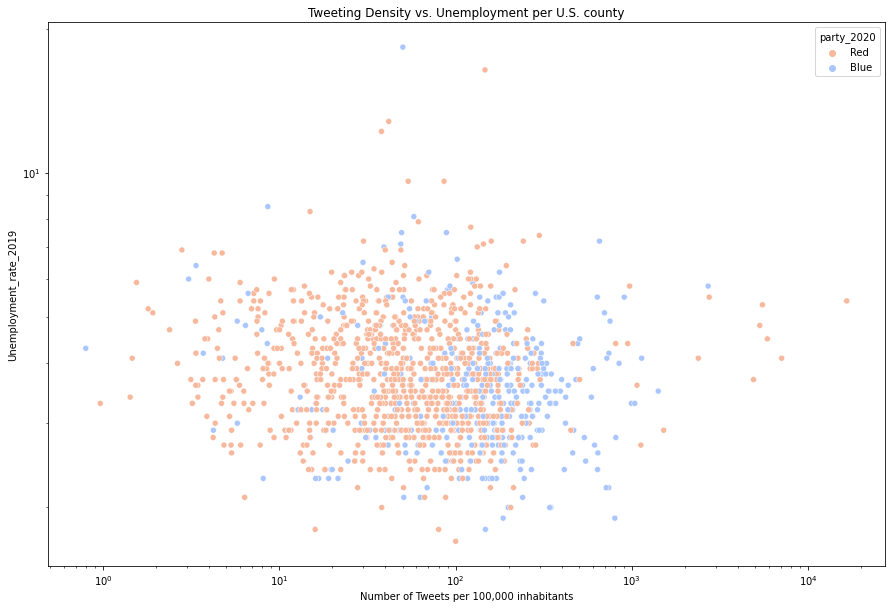

In [56]:
fig, ax = plt.subplots(figsize=(15,10)) ##[counties_tp['tweet_count']<100]
sns.scatterplot(data=counties_tp[(counties_tp['tweet_count_100k']!=0)&(counties_tp['protest_count_100k']!=0)], x='tweet_count_100k', y='Unemployment_rate_2019',
               hue = "party_2020", palette = "coolwarm_r")
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylabel("Unemployment_rate_2019")
ax.set_xlabel("Number of Tweets per 100,000 inhabitants")
plt.title("Tweeting Density vs. Unemployment per U.S. county")

Text(0.5, 1.0, 'Tweeting Density vs. Education per U.S. county')

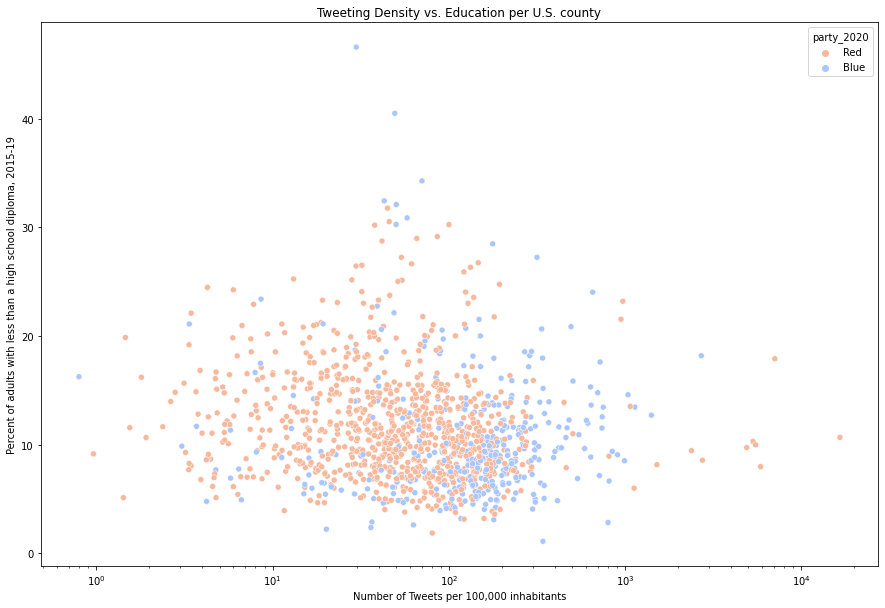

In [57]:
fig, ax = plt.subplots(figsize=(15,10)) ##[counties_tp['tweet_count']<100]
sns.scatterplot(data=counties_tp[(counties_tp['tweet_count_100k']!=0)&(counties_tp['protest_count_100k']!=0)], x='tweet_count_100k', y='Percent of adults with less than a high school diploma, 2015-19',
               hue = "party_2020", palette = "coolwarm_r")
ax.set_xscale('log')
# ax.set_yscale('log')

ax.set_ylabel("Percent of adults with less than a high school diploma, 2015-19")
ax.set_xlabel("Number of Tweets per 100,000 inhabitants")
plt.title("Tweeting Density vs. Education per U.S. county")

Text(0.5, 1.0, 'Tweeting Density vs. Poverty rate per U.S. county')

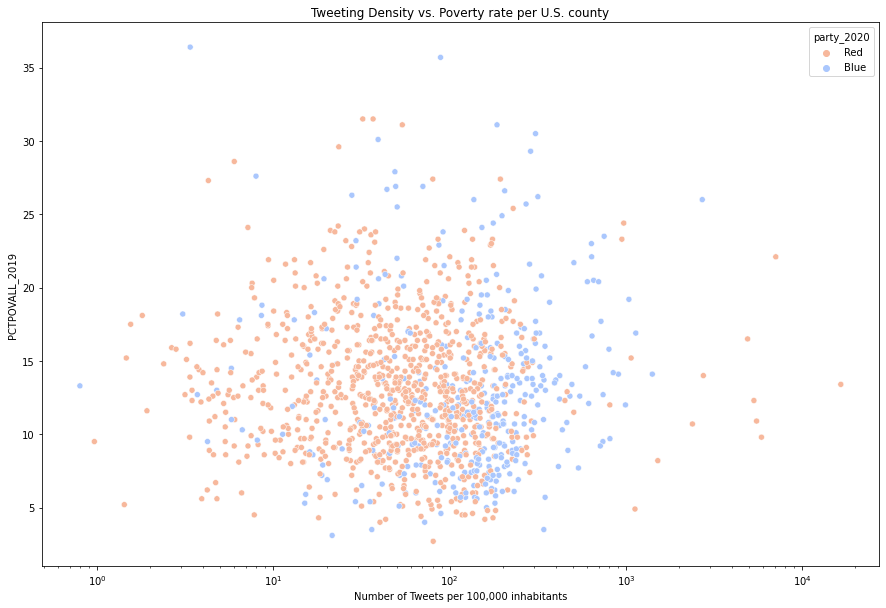

In [58]:
fig, ax = plt.subplots(figsize=(15,10)) ##[counties_tp['tweet_count']<100]
sns.scatterplot(data=counties_tp[(counties_tp['tweet_count_100k']!=0)&(counties_tp['protest_count_100k']!=0)], x='tweet_count_100k', y='PCTPOVALL_2019',
               hue = "party_2020", palette = "coolwarm_r")
ax.set_xscale('log')
# ax.set_yscale('log')

ax.set_ylabel("PCTPOVALL_2019")
ax.set_xlabel("Number of Tweets per 100,000 inhabitants")
plt.title("Tweeting Density vs. Poverty rate per U.S. county")

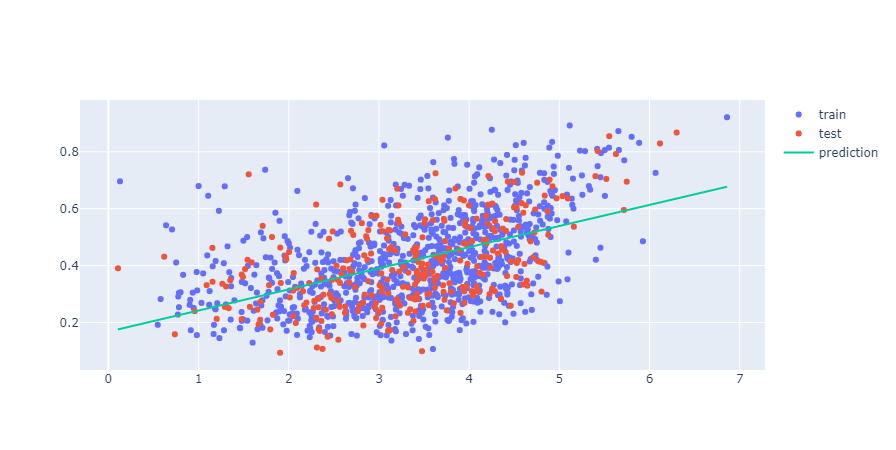

In [167]:
import plotly.express as px
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

df = counties_tp[(counties_tp['tweet_count_100k']!=0)&(counties_tp['protest_count_100k']!=0)][['tweet_count_100k', 'per_dem']]
X = np.log(df.tweet_count_100k[:, None])
X_train, X_test, y_train, y_test = train_test_split(X, df.per_dem, random_state=0)

model = LinearRegression()
model.fit(X_train, y_train)

x_range = np.linspace(X.min(), X.max(), 100)
y_range = model.predict(x_range.reshape(-1, 1))


fig = go.Figure([
    go.Scatter(x=X_train.squeeze(), y=y_train, name='train', mode='markers'),
    go.Scatter(x=X_test.squeeze(), y=y_test, name='test', mode='markers'),
    go.Scatter(x=x_range, y=y_range, name='prediction')
])

fig.show()

In [116]:
# fig, ax = plt.subplots(figsize=(15,10)) ##[counties_tp['tweet_count']<100]
# sns.scatterplot(data=counties_tp[(counties_tp['tweet_count']!=0)&(counties_tp['protest_count']!=0)], x='tweet_count_100k', y='per_gop',
#                hue = "party", palette = "coolwarm_r", size = "per_point_diff_abs")
# ax.set_xscale('log')
# # ax.set_yscale('log')

# ax.set_ylabel("% Republican Votes")
# ax.set_xlabel("Number of Tweets per 100,000 inhabitants")
# plt.title("Number of protests vs. number of Tweets per U.S. county")

Text(0.5, 1.0, 'Number of protests vs. % Democrat Votes per U.S. county')

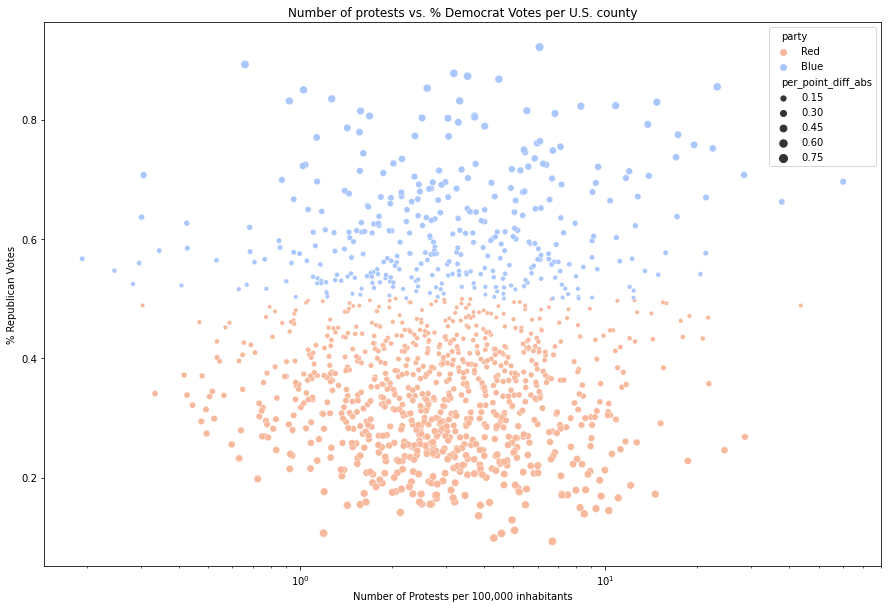

In [115]:
fig, ax = plt.subplots(figsize=(15,10)) ##[counties_tp['tweet_count']<100]
sns.scatterplot(data=counties_tp[(counties_tp['tweet_count']!=0)&(counties_tp['protest_count']!=0)], x='protest_count_100k', y='per_dem',
               hue = "party", palette = "coolwarm_r", size = "per_point_diff_abs")
ax.set_xscale('log')
# ax.set_yscale('log')

ax.set_ylabel("% Republican Votes")
ax.set_xlabel("Number of Protests per 100,000 inhabitants")
plt.title("Number of protests vs. % Democrat Votes per U.S. county")

In [36]:
# counties_tp

### Zipf's Law

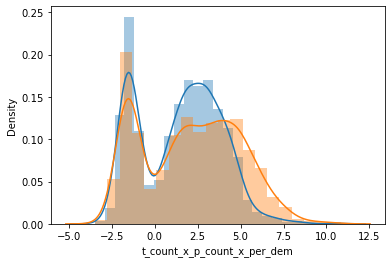

In [61]:
counties_tp['tweet_count_x_per_dem'] = (1+counties_tp['tweet_count_100k'])*(counties_tp['per_dem_2020'])
sns.distplot(np.log(counties_tp['tweet_count_x_per_dem']))
#
counties_tp['t_count_x_p_count_x_per_dem'] = (1+counties_tp['tweet_count_100k'])*(1+counties_tp['protest_count_100k'])*(counties_tp['per_dem_2020'])
sns.distplot(np.log(counties_tp['t_count_x_p_count_x_per_dem']))

In [62]:
counties_tp.sort_values('tweet_count_x_per_dem', inplace=True, ascending=False)
counties_tp['tweet_count_x_per_dem_rank'] = np.arange(0, len(counties_tp))
#
counties_tp.sort_values('t_count_x_p_count_x_per_dem', inplace=True, ascending=False)
counties_tp['t_count_x_p_count_x_per_dem_rank'] = np.arange(0, len(counties_tp))

In [191]:
# counties_tp

Text(0.5, 1.0, "Tweeting Density * % Democratic Votes per U.S. county follows Zipf's Law")

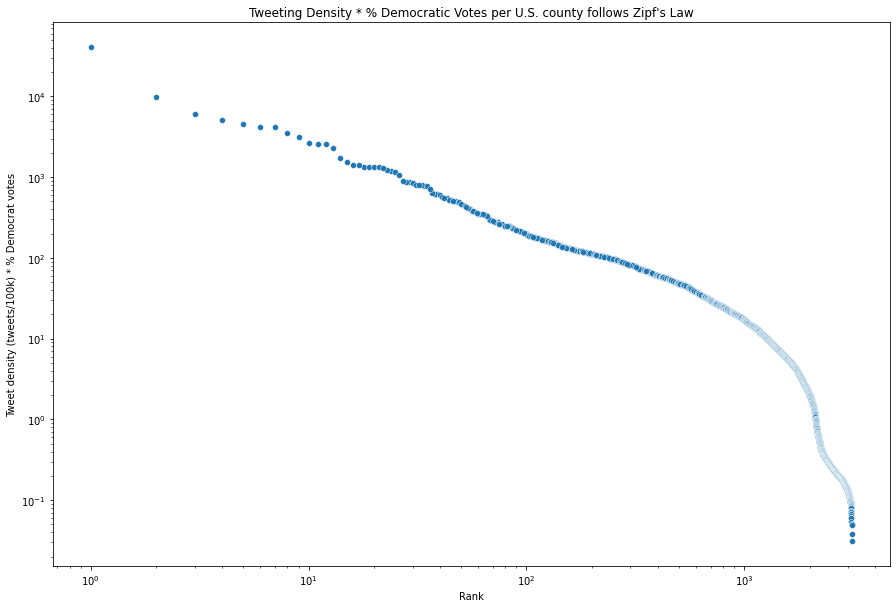

In [65]:
fig, ax = plt.subplots(figsize=(15,10))
sns.scatterplot(data=counties_tp[counties_tp['tweet_count_x_per_dem_rank']!=0], y='tweet_count_x_per_dem', x='tweet_count_x_per_dem_rank')
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylabel("Tweet density (tweets/100k) * % Democrat votes")
ax.set_xlabel("Rank")
plt.title("Tweeting Density * % Democratic Votes per U.S. county follows Zipf's Law")

Text(0.5, 1.0, "Tweeting Density * Protest density * % Democratic Votes per U.S. county follows Zipf's Law")

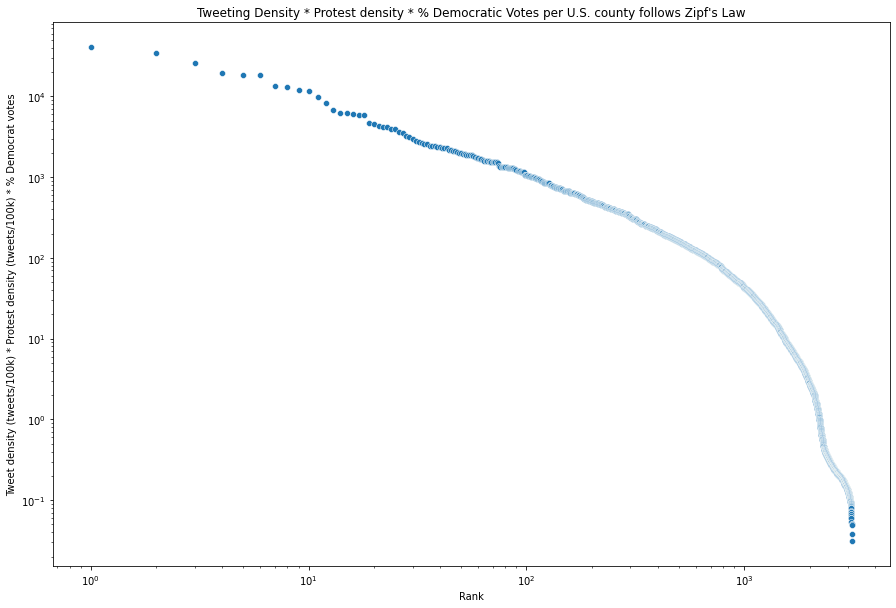

In [64]:
fig, ax = plt.subplots(figsize=(15,10))
sns.scatterplot(data=counties_tp[counties_tp['t_count_x_p_count_x_per_dem_rank']!=0], y='t_count_x_p_count_x_per_dem', x='t_count_x_p_count_x_per_dem_rank')
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylabel("Tweet density (tweets/100k) * Protest density (tweets/100k) * % Democrat votes")
ax.set_xlabel("Rank")
plt.title("Tweeting Density * Protest density * % Democratic Votes per U.S. county follows Zipf's Law")

#### Precincts

In [247]:
### next, spatial join number of protests per county, number of tweets per county, color by policy implemented
### scatter plot tweets vs protests
from functools import reduce
# load counties
precincts = gpd.read_file("../us_admin/precincts-with-results.geojson/precincts-with-results.geojson")

In [97]:
# convert both protests and tweets to gdfs
gdf_p = gpd.GeoDataFrame(
    df_p, geometry=gpd.points_from_xy(df_p.LONGITUDE, df_p.LATITUDE), crs=counties.crs)

tweets_gdf = gpd.GeoDataFrame(
    tweets_df_geo, geometry=gpd.points_from_xy(tweets_df_geo.lng, tweets_df_geo.lat), crs=counties.crs)

In [252]:
# interpolate protests and tweets per county (sum on tweet_count and protest_count)
precincts_p = gpd.sjoin(gdf_p, precincts, how='right') 
precincts_p = precincts_p.groupby(['GEOID']).sum().reset_index()[['GEOID', 'protest_count']]

In [253]:
# interpolate protests and tweets per county (sum on tweet_count and protest_count)
precincts_t = gpd.sjoin(tweets_gdf, precincts, how='right')
precincts_t = precincts_t.groupby(['GEOID']).sum().reset_index()[['GEOID', 'tweet_count']]

In [255]:
# # presidential elections
# counties_e = pd.read_csv("https://raw.githubusercontent.com/tonmcg/US_County_Level_Election_Results_08-20/master/2020_US_County_Level_Presidential_Results.csv", converters={'county_fips': str})
# counties_e.columns = ['state_name', 'GEOID', 'NAMELSAD', 'votes_gop', 'votes_dem', 
#                     'total_votes', 'diff', 'per_gop', 'per_dem', 'per_point_diff']

# counties_e["per_point_diff_abs"] = np.abs(counties_e["per_point_diff"])

In [256]:
dfs = [precincts_t, precincts_p, precincts]

precincts_tp = gpd.GeoDataFrame(reduce(lambda left,right: pd.merge(left,right,on='GEOID'), dfs))

In [270]:
# counties_tp['tweet_count_100k'] = (counties_tp['tweet_count']/counties_tp['POP_ESTIMATE_2019'])*100000
# counties_tp['protest_count_100k'] = (counties_tp['protest_count']/counties_tp['POP_ESTIMATE_2019'])*100000
precincts_tp['per_dem'] = precincts_tp['votes_dem']/precincts_tp['votes_total']

precincts_tp['party'] = ""
precincts_tp['party'][precincts_tp['per_dem']<0.5] = "Red"
precincts_tp['party'][precincts_tp['per_dem']>=0.5] = "Blue"

In [271]:
precincts_tp.describe()

,tweet_count,protest_count,votes_dem,votes_rep,votes_total,votes_per_sqkm,pct_dem_lead,per_dem
count,145408.000000,145408.000000,145312.000000,145312.000000,145312.000000,145312.000000,141421.000000,141421.000000
mean,1.815423,0.047480,502.366439,439.649114,960.092463,1075.225303,3.259484,0.506602
std,60.549875,0.770073,836.332389,632.964765,1353.559163,4433.418794,46.689777,0.233495
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-100.000000,0.000000
25%,0.000000,0.000000,136.000000,113.000000,366.000000,22.400000,-33.300000,0.323988
50%,0.000000,0.000000,329.000000,284.000000,662.000000,337.500000,1.300000,0.496933
75%,0.000000,0.000000,617.000000,541.000000,1164.000000,958.400000,38.300000,0.680529
max,13547.000000,111.000000,78209.000000,32778.000000,96247.000000,987935.300000,100.000000,1.000000


Text(0.5, 1.0, 'Number of protests vs. number of Tweets per U.S. county')

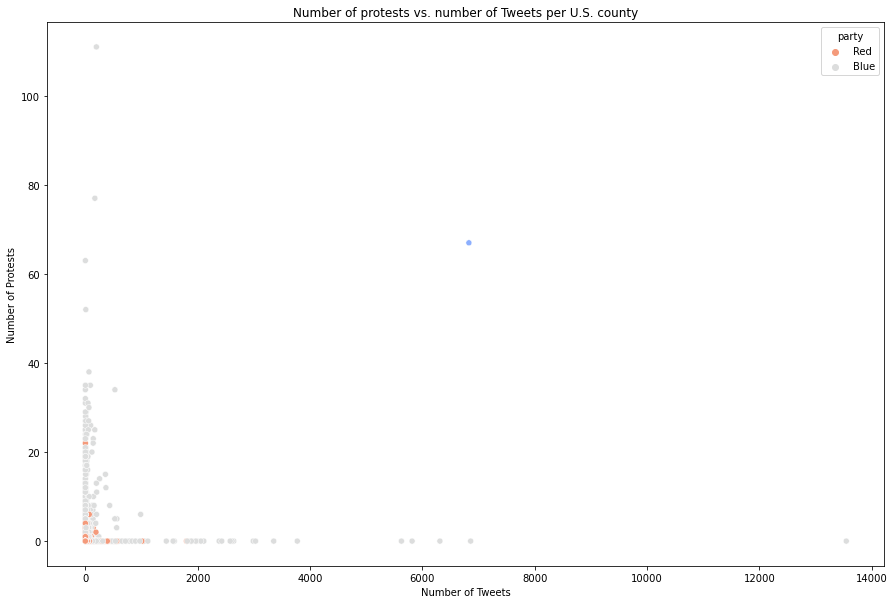

In [277]:
fig, ax = plt.subplots(figsize=(15,10)) ##[counties_tp['tweet_count']<100]
sns.scatterplot(data=precincts_tp[(precincts_tp['tweet_count']!=0)&(precincts_tp['protest_count']!=0)], 
                x='tweet_count', y='protest_count', hue = "party", palette = "coolwarm_r") 

# ax.set_xscale('log')
# ax.set_yscale('log')

ax.set_ylabel("Number of Protests")
ax.set_xlabel("Number of Tweets")
plt.title("Number of protests vs. number of Tweets per U.S. county")

Text(0.5, 1.0, 'Number of protests vs. number of Tweets per U.S. county')

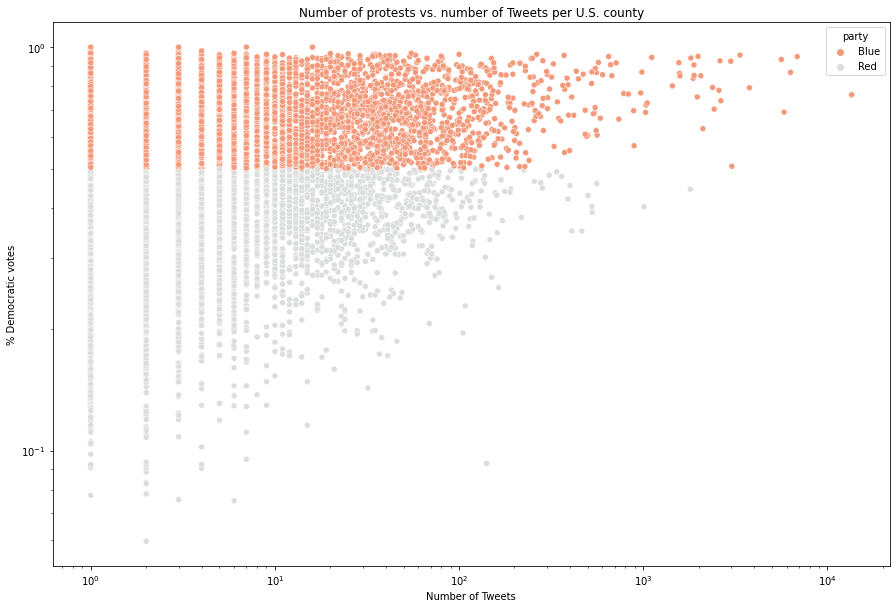

In [304]:
fig, ax = plt.subplots(figsize=(15,10)) ##[counties_tp['tweet_count']<100]
sns.scatterplot(data=precincts_tp[(precincts_tp['tweet_count']!=0)&(precincts_tp['votes_dem']!=0)], 
                x='tweet_count', y='per_dem', hue = "party", palette = "coolwarm_r") 

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylabel("% Democratic votes")
ax.set_xlabel("Number of Tweets")
plt.title("Number of protests vs. number of Tweets per U.S. county")

Text(0.5, 1.0, 'Number of protests vs. number of Tweets per U.S. county')

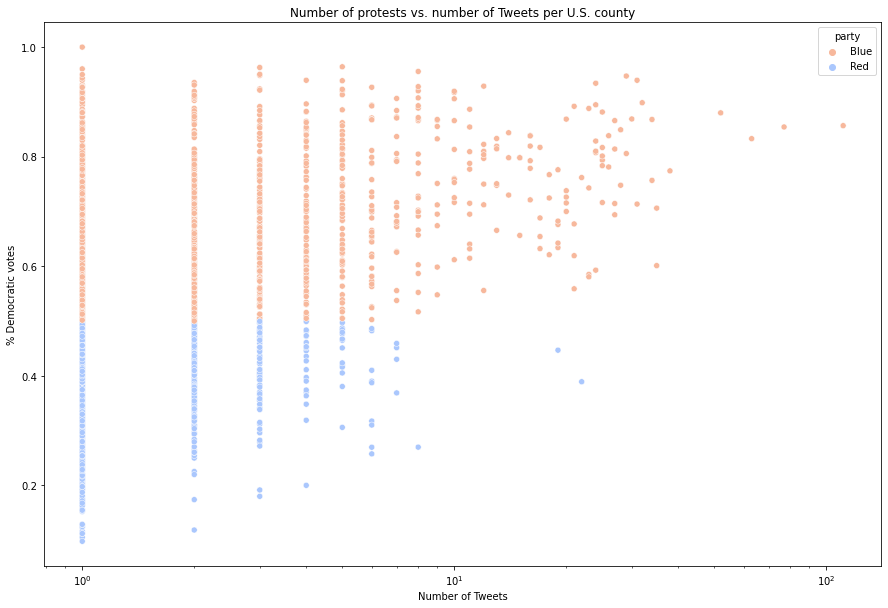

In [298]:
fig, ax = plt.subplots(figsize=(15,10)) ##[counties_tp['tweet_count']<100]
sns.scatterplot(data=precincts_tp[(precincts_tp['protest_count']!=0)&(precincts_tp['votes_dem']!=0)], 
                x='protest_count', y='per_dem', hue = "party", palette = "coolwarm_r") 

ax.set_xscale('log')
# ax.set_yscale('log')

ax.set_ylabel("% Democratic votes")
ax.set_xlabel("Number of Tweets")
plt.title("Number of protests vs. number of Tweets per U.S. county")

In [302]:
precincts_tp.to_file("../processed/precincts-tweets.geojson", driver = "GeoJSON")

#### Zip Code

In [311]:
### next, spatial join number of protests per county, number of tweets per county, color by policy implemented
### scatter plot tweets vs protests
from functools import reduce
# load counties
zipc = gpd.read_file("../us_admin/cb_2019_us_zcta510_500k.shp")[['ZCTA5CE10', 'geometry']]
zipc_pop = gpd.read_file("../pop-by-zip-code.csv")[["zip_code","y-2016"]]
zipc = pd.merge(zipc, zipc_pop, left_on="ZCTA5CE10", right_on="zip_code")

In [97]:
# convert both protests and tweets to gdfs
gdf_p = gpd.GeoDataFrame(
    df_p, geometry=gpd.points_from_xy(df_p.LONGITUDE, df_p.LATITUDE), crs=counties.crs)

tweets_gdf = gpd.GeoDataFrame(
    tweets_df_geo, geometry=gpd.points_from_xy(tweets_df_geo.lng, tweets_df_geo.lat), crs=counties.crs)

In [314]:
# interpolate protests and tweets per county (sum on tweet_count and protest_count)
zipc_p = gpd.sjoin(gdf_p, zipc, how='right') 
zipc_p = zipc_p.groupby(['zip_code']).sum().reset_index()[['zip_code', 'protest_count']]

In [315]:
# interpolate protests and tweets per county (sum on tweet_count and protest_count)
zipc_t = gpd.sjoin(tweets_gdf, zipc, how='right')
zipc_t = zipc_t.groupby(['zip_code']).sum().reset_index()[['zip_code', 'tweet_count']]

In [255]:
# # presidential elections
# counties_e = pd.read_csv("https://raw.githubusercontent.com/tonmcg/US_County_Level_Election_Results_08-20/master/2020_US_County_Level_Presidential_Results.csv", converters={'county_fips': str})
# counties_e.columns = ['state_name', 'GEOID', 'NAMELSAD', 'votes_gop', 'votes_dem', 
#                     'total_votes', 'diff', 'per_gop', 'per_dem', 'per_point_diff']

# counties_e["per_point_diff_abs"] = np.abs(counties_e["per_point_diff"])

In [317]:
dfs = [zipc_t, zipc_p, zipc]

zipc_tp = gpd.GeoDataFrame(reduce(lambda left,right: pd.merge(left,right,on='zip_code'), dfs))

In [324]:
zipc_tp['tweet_count_100k'] = (zipc_tp['tweet_count']/pd.to_numeric(zipc_tp['y-2016']))*100000
zipc_tp['protest_count_100k'] = (zipc_tp['protest_count']/pd.to_numeric(zipc_tp['y-2016']))*100000

Text(0.5, 1.0, 'Number of protests vs. number of Tweets per U.S. county')

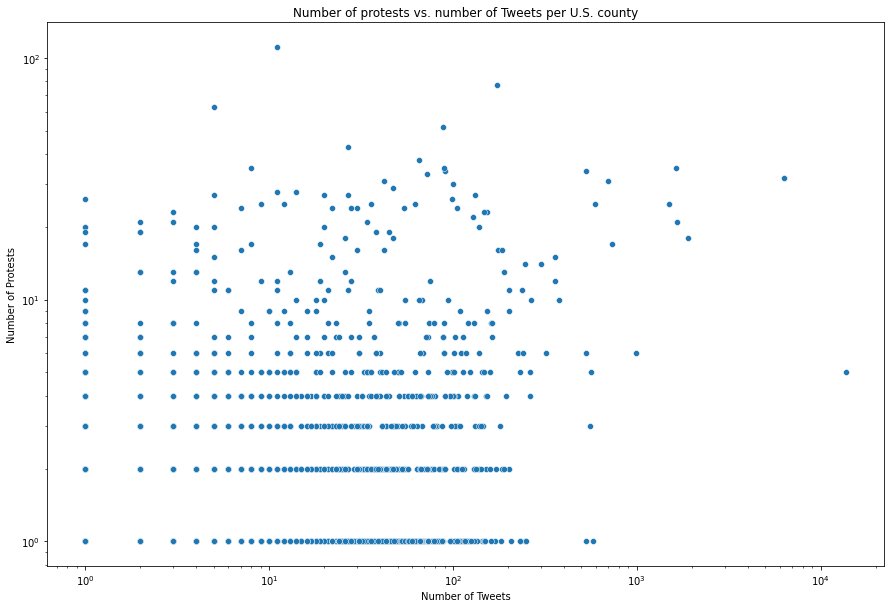

In [326]:
fig, ax = plt.subplots(figsize=(15,10)) ##[counties_tp['tweet_count']<100]
sns.scatterplot(data=zipc_tp[(zipc_tp['tweet_count']!=0)&(zipc_tp['protest_count']!=0)], 
                x='tweet_count', y='protest_count') 

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylabel("Number of Protests")
ax.set_xlabel("Number of Tweets")
plt.title("Number of protests vs. number of Tweets per U.S. county")

Text(0.5, 1.0, 'Number of protests vs. number of Tweets per U.S. county')

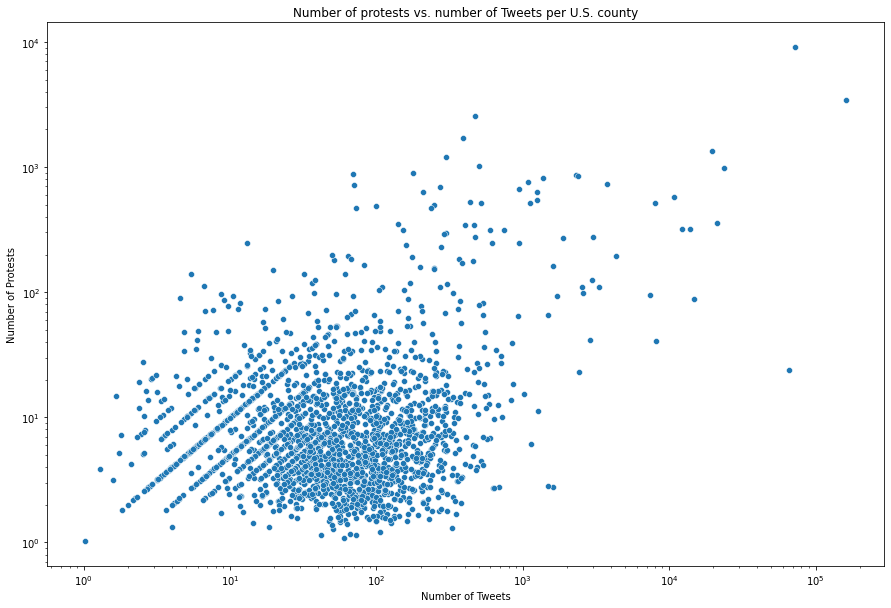

In [328]:
fig, ax = plt.subplots(figsize=(15,10)) ##[counties_tp['tweet_count']<100]
sns.scatterplot(data=zipc_tp[(zipc_tp['tweet_count']!=0)&(zipc_tp['protest_count']!=0)], 
                x='tweet_count_100k', y='protest_count_100k') 

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylabel("Number of Protests")
ax.set_xlabel("Number of Tweets")
plt.title("Number of protests vs. number of Tweets per U.S. county")

In [330]:
zipc_tp.to_file("../processed/tweets_zpta_geo.geojson", driver = "GeoJSON")

### Sentiment Analysis using Vader

In [11]:
%%time
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)        
    return input_txt
def clean_tweets(tweets):
    #remove twitter Return handles (RT @xxx:)
    tweets = np.vectorize(remove_pattern)(tweets, "RT @[\w]*:") 
    
    #remove twitter handles (@xxx)
    tweets = np.vectorize(remove_pattern)(tweets, "@[\w]*")
    
    #remove URL links (httpxxx)
    tweets = np.vectorize(remove_pattern)(tweets, "https?://[A-Za-z0-9./]*")

    #remove special characters, numbers, punctuations (except for #)
    tweets = np.core.defchararray.replace(tweets, "[^a-zA-Z]", " ")
    
    return tweets

tweets_df['clean_text']= clean_tweets(tweets_df['clean_text'].astype('str')) #The function clean_tweets were put to use.
# tweets_df.tail()

Wall time: 13.4 s


In [80]:
%%time
#importing and initialising the VADER analyser
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

#Storing the scores in list of dictionaries
scores = []
# Declare variables for scores
compound_list = []
positive_list = []
negative_list = []
neutral_list = []
for i in range(tweets_df['clean_text'].shape[0]):
#print(analyser.polarity_scores(sentiments_pd['Tweet'][i]))
    compound = analyzer.polarity_scores(tweets_df['clean_text'][i])["compound"]
    pos = analyzer.polarity_scores(tweets_df['clean_text'][i])["pos"]
    neu = analyzer.polarity_scores(tweets_df['clean_text'][i])["neu"]
    neg = analyzer.polarity_scores(tweets_df['clean_text'][i])["neg"]
    
    scores.append({"compound_s": compound,
                       "positive_s": pos,
                       "negative_s": neg,
                       "neutral_s": neu
                  })

#Appending the scores into the dataframe for further analysis 
sentiments_score = pd.DataFrame.from_dict(scores)
tweets_df_sent = tweets_df.join(sentiments_score)

Wall time: 29min 42s


In [81]:
# tweets_df_sent.to_csv('../2Mtweets_sentiment.csv')

In [13]:
%%time
# import vaex
# tweets_df_sent = vaex.open('../2Mtweets_sentiment.csv')
tweets_df_sent = pd.read_csv('../2Mtweets_sentiment.csv')

C:\Users\Leonardo\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Wall time: 20.6 s


In [14]:
tweets_df_sent.head(5)

C:\Users\Leonardo\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Unnamed: 0,tweet_id,created_at,source,text,full_text,clean_text,is_retweet,sentiment,polarity,...,user_friends,user_followers,original_author,hashtags,retweet_count,favorite_count,compound_s,positive_s,negative_s,neutral_s
0,0,1275268627676217345,Tue Jun 23 03:25:08 +0000 2020,"<a href=""http://twitter.com/download/iphone"" r...",RT @DangeRussWilson: The only thing that must ...,The only thing that must die... is \nRACISM.,The thing must die ... RACISM,True,"Sentiment(polarity=0.0, subjectivity=0.0)",0.000000,...,209,341,DangeRussWilson,NaN,10540.0,65764.0,-0.8668,0.000,0.686,0.314
1,1,1275268628225679361,Tue Jun 23 03:25:08 +0000 2020,"<a href=""https://mobile.twitter.com"" rel=""nofo...",RT @CIAspygirl: Kayleigh McEnany is only 32. A...,Kayleigh McEnany is only 32. And no matter wha...,Kayleigh McEnany And matter accomplishes lifet...,True,"Sentiment(polarity=0.0, subjectivity=0.0)",0.000000,...,1322,280,CIAspygirl,NaN,2844.0,11045.0,-0.7430,0.174,0.370,0.457
2,2,1275268628305281025,Tue Jun 23 03:25:08 +0000 2020,"<a href=""http://twitter.com/download/android"" ...",RT @TheLeoTerrell: Attention Black Lives Matte...,Attention Black Lives Matter. During Father Da...,Attention Black Lives Matter During Father Day...,True,"Sentiment(polarity=-0.12777777777777777, subje...",-0.127778,...,2614,1699,TheLeoTerrell,NaN,10960.0,18739.0,-0.8860,0.108,0.318,0.575
3,3,1275268628116619266,Tue Jun 23 03:25:08 +0000 2020,"<a href=""http://twitter.com/download/iphone"" r...",RT @letarik_b: THIS BLACK BOY WHO PLAYED THE V...,THIS BLACK BOY WHO PLAYED THE VIOLIN FOR KITTE...,THIS BLACK BOY WHO PLAYED THE VIOLIN FOR KITTE...,True,"Sentiment(polarity=-0.18888888888888888, subje...",-0.188889,...,219,74,letarik_b,['ElijahMcClain'],191498.0,270442.0,-0.7526,0.109,0.195,0.696
4,4,1275268627667628033,Tue Jun 23 03:25:08 +0000 2020,"<a href=""http://twitter.com/download/iphone"" r...",RT @ciarralifts: In case you haven’t heard it ...,"In case you haven’t heard it yet today, black ...",In case havent heard yet today black lives fuc...,True,"Sentiment(polarity=-0.3833333333333333, subjec...",-0.383333,...,685,575,ciarralifts,NaN,33.0,82.0,0.1010,0.134,0.000,0.866


C:\Users\Leonardo\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 0, 'Compound Sentiment')

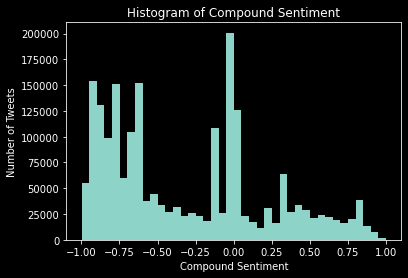

In [15]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.hist(tweets_df_sent['compound_s'].values, bins=40)
plt.title('Histogram of Compound Sentiment')
plt.ylabel('Number of Tweets')
plt.xlabel('Compound Sentiment')

In [25]:
from wordcloud import WordCloud
from PIL import Image
from wordcloud import ImageColorGenerator
# import image
# char_mask = np.array(Image.open("IMAGE_FILE.jpg"))
# image_colors = ImageColorGenerator(char_mask) # to recolor the word cloud to represent the colours from the image
# generate wordcloud
print('Generating word cloud....')
# wc = WordCloud(background_color="black", max_words=700, width=1600, height=800,
# mask=char_mask, random_state=1).generate(' '.join(df['Tweet'])) #max_words must be less than number of unique words in your data

wc = WordCloud(background_color="black", max_words=700, width=1600, height=800, random_state=1).generate(' '.join(tweets_df_sent['clean_text']))
    
print('Making plot')
plt.figure(figsize=(20,10))
ypos = 800
plt.style.use('dark_background')
plt.imshow(wc) #Shows the word cloud
plt.axis("off") 
# plt.savefig('blm.png') #to save the figure into your system

In [ ]:
# list(tweets_df_sent['full_text'].values)

Text(0.5, 0, 'Retweets')

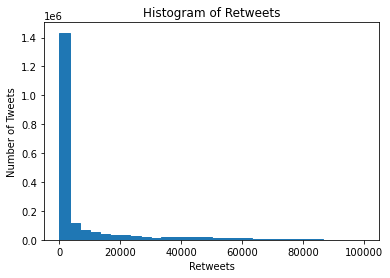

In [64]:
import matplotlib.pyplot as plt
n_bins= 30
plt.hist(tweets_df['retweet_count'][tweets_df['retweet_count']<100000], n_bins, histtype='step', stacked=True, fill = True)
plt.title('Histogram of Retweets')
plt.ylabel('Number of Tweets')
plt.xlabel('Retweets')

In [66]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(tweets_df['created_at'], tweets_df['polarity'])
plt.title('Tweet polarity over the course of one day (june 23rd)')
plt.ylabel('Polarity')
plt.xlabel('Time of Day')

# Topic Modelling

In [47]:
!pip install emoji --upgrade
# !pip install pandas-profiling==2.*
# !pip install plotly==4.*
!pip install spacy
!python -m spacy download en_core_web_lg
!pip install pyldavis
!pip install gensim
# !pip install chart_studio
!pip install --upgrade autopep8

In [21]:
# Required Libraries
import warnings
warnings.filterwarnings('ignore')
#Base and Cleaning 
import json
import requests
import pandas as pd
import numpy as np
import emoji
import regex
import re
import string
from collections import Counter

#Visualizations
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt 
import pyLDAvis.gensim
import chart_studio
import chart_studio.plotly as py 
import chart_studio.tools as tls

#Natural Language Processing (NLP)
import spacy
import gensim
from spacy.tokenizer import Tokenizer
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS as SW
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from wordcloud import STOPWORDS
stopwords = set(STOPWORDS)

C:\Users\Leonardo\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [44]:
# def give_emoji_free_text(text):
#     """
#     Removes emoji's from tweets
#     Accepts:
#         Text (tweets)
#     Returns:
#         Text (emoji free tweets)
#     """
#     emoji_list = [c for c in text if c in emoji.UNICODE_EMOJI]
#     clean_text = ' '.join([str for str in text.split() if not any(i in str for i in emoji_list)])
#     return clean_text

# def url_free_text(text):
#     '''
#     Cleans text from urls
#     '''
#     text = re.sub(r'http\S+', '', text)
#     return text

# # Apply the function above and get tweets free of emoji's
# call_emoji_free = lambda x: give_emoji_free_text(x)

# # Apply `call_emoji_free` which calls the function to remove all emoji's
# df['emoji_free_tweets'] = df['original_tweets'].apply(call_emoji_free)

# #Create a new column with url free tweets
# df['url_free_tweets'] = df['emoji_free_tweets'].apply(url_free_text)

### Tokenization
Tokenization is always the first step before we can do any text data processing. What this means is that spaCy will segment sentences into words, punctuations, symbols and others by applying specific rules to each language. Spacy is a pre-trained natural language processing model capable of figuring out the relationship between words. You can learn more about Spacy here.

In [41]:
# drop NaN tweets
tweets_df_sent.dropna(subset = ['clean_text', 'full_text'], inplace=True)

In [42]:
nlp = spacy.load('en_core_web_lg')
# Tokenizer
tokenizer = Tokenizer(nlp.vocab)


# Custom stopwords
custom_stopwords = ['hi','\n','\n\n', '&amp;', ' ', '.', '-', 'got', "it's", 'it’s', "i'm", 'i’m', 'im', 'want', 'like', '$', '@']

# Customize stop words by adding to the default list
STOP_WORDS = nlp.Defaults.stop_words.union(custom_stopwords)

# ALL_STOP_WORDS = spacy + gensim + wordcloud
ALL_STOP_WORDS = STOP_WORDS.union(SW).union(stopwords)


tokens = []

for doc in tokenizer.pipe(tweets_df_sent['clean_text'], batch_size=500):
    doc_tokens = []    
    for token in doc: 
        if token.text.lower() not in STOP_WORDS:
            doc_tokens.append(token.text.lower())   
    tokens.append(doc_tokens)

# Makes tokens column
tweets_df_sent['tokens'] = tokens

### Lemmetization
Lemmatization is a process where we convert words to its root word. For example: ‘Studying’ becomes ‘Study’, ‘Meeting becomes ‘Meet’, ‘Better’ and ‘Best’ become ‘Good’.The advantage of this is, we get to reduce the total number of unique words in the dictionary. As a result, the number of columns in the document-word matrix will be denser with lesser columns. The ultimate goal of lemmatization is to help the LDA model to produce better topics in the end.

In [44]:
# Make tokens a string again
tweets_df_sent['tokens_back_to_text'] = [' '.join(map(str, l)) for l in tweets_df_sent['tokens']]

def get_lemmas(text):
    '''Used to lemmatize the processed tweets'''
    lemmas = []
    
    doc = nlp(text)
    
    # Something goes here :P
    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_ != 'PRON'):
            lemmas.append(token.lemma_)
    
    return lemmas

tweets_df_sent['lemmas'] = tweets_df_sent['tokens_back_to_text'].apply(get_lemmas)

In [45]:
# Make lemmas a string again
tweets_df_sent['lemmas_back_to_text'] = [' '.join(map(str, l)) for l in tweets_df_sent['lemmas']]

# Tokenizer function
def tokenize(text):
    """
    Parses a string into a list of semantic units (words)
    Args:
        text (str): The string that the function will tokenize.
    Returns:
        list: tokens parsed out
    """
    # Removing url's
    pattern = r"http\S+"
    
    tokens = re.sub(pattern, "", text) # https://www.youtube.com/watch?v=O2onA4r5UaY
    tokens = re.sub('[^a-zA-Z 0-9]', '', text)
    tokens = re.sub('[%s]' % re.escape(string.punctuation), '', text) # Remove punctuation
    tokens = re.sub('\w*\d\w*', '', text) # Remove words containing numbers
    tokens = re.sub('@*!*\$*', '', text) # Remove @ ! $
    tokens = tokens.strip(',') # TESTING THIS LINE
    tokens = tokens.strip('?') # TESTING THIS LINE
    tokens = tokens.strip('!') # TESTING THIS LINE
    tokens = tokens.strip("'") # TESTING THIS LINE
    tokens = tokens.strip(".") # TESTING THIS LINE

    tokens = tokens.lower().split() # Make text lowercase and split it
    
    return tokens

# Apply tokenizer
tweets_df_sent['lemma_tokens'] = tweets_df_sent['lemmas_back_to_text'].apply(tokenize)

In [46]:
tweets_df_sent.to_csv('../2Mtweets_sentiment_lt.csv')

In [11]:
data = pd.read_csv('100000_tweets.csv')

In [2]:
# Stream a user timeline
import tweepy
from tweepy import OAuthHandler
import json
 
consumer_key = 'BrfwPUQwUrXrTI8PsbpQLd8cY'
consumer_secret = '71FyuTaHH6qoPZdilbXONYRn9mURCSJLGgJYpFzdscmzCrGY9N'
access_token = '306806203-TCvwu2u4fKPEPJE6OQnc1s7VuIGNYb3cbDPK9h49'
access_secret = 'b1COlCPF0eUIb74vsw01lV0maoy28nxYlKvt5W4lL1phz'
 
@classmethod
def parse(cls, api, raw):
    status = cls.first_parse(api, raw)
    setattr(status, 'json', json.dumps(raw))
    return status
 
# Status() is the data model for a tweet
tweepy.models.Status.first_parse = tweepy.models.Status.parse
tweepy.models.Status.parse = parse
# User() is the data model for a user profile
tweepy.models.User.first_parse = tweepy.models.User.parse
tweepy.models.User.parse = parse
# You need to do it for all the models you need
 
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
 
api = tweepy.API(auth)

In [208]:
username = 'greg_doucette'
tweets = []
for tweet in tweepy.Cursor(api.user_timeline, id=username, tweet_mode='extended').items():
    tweets += tweet.status

0

In [3]:
import sys
print(sys.getrecursionlimit())
sys.setrecursionlimit(5000)
username = 'greg_doucette'
def get_all_tweets(screen_name):
    #Twitter only allows access to a users most recent 3240 tweets with this method
    
    #authorize twitter, initialize tweepy
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_secret)
    api = tweepy.API(auth)
    
    #initialize a list to hold all the tweepy Tweets
    alltweets = []  
    
    #make initial request for most recent tweets (200 is the maximum allowed count)
    new_tweets = api.user_timeline(screen_name = screen_name,count=200, tweet_mode='extended')
    
    #save most recent tweets
    alltweets.extend(new_tweets)
    
    #save the id of the oldest tweet less one
    oldest = alltweets[-1].id - 1
    
    #keep grabbing tweets until there are no tweets left to grab
    while len(new_tweets) > 0:
        print(f"getting tweets before {oldest}")
        
        #all subsiquent requests use the max_id param to prevent duplicates
        new_tweets = api.user_timeline(screen_name = screen_name,count=200,max_id=oldest, tweet_mode='extended')
        
        #save most recent tweets
        alltweets.extend(new_tweets)
        
        #update the id of the oldest tweet less one
        oldest = alltweets[-1].id - 1
        
        print(f"...{len(alltweets)} tweets downloaded so far")
        
    return alltweets

3000


In [5]:
tweets = get_all_tweets(username)

In [34]:
len(tweet_files)

3203

In [18]:
# save tweets to file
tweet_files = []
for status in tweets:
    tweet_files.append(status._json)
# write files
with open(username + "3200_extended_tweets.json", 'w') as f:
    json.dump(tweet_files, f)

In [30]:
tweets = []
for line in open('greg_doucette3200_extended_tweets.json', 'r'):
    tweets.append(json.loads(line))

In [27]:
video_urls = []
text = []
created_at = []
location = []
for tweet in range(len(tweet_files)-1):
    if 'extended_entities' in tweet_files[tweet].keys():
        if tweet_files[tweet]['extended_entities']['media'][0]['type'] == 'video':
#         if tweet_files[tweet]['in_reply_to_status_id_str'] == '1268773302421651462':
#         if 'media' in tweet_files[tweet]['extended_entities'].keys():
            try:
                video_urls.append(tweet_files[tweet]['extended_entities']['media'][0]['video_info']['variants'][1]['url'])
            except KeyError:
                video_urls.append(None)
            text.append(tweet_files[tweet]['full_text'])
            created_at.append(tweet_files[tweet]['created_at'])
            location.append(tweet_files[tweet]['full_text'].split(":")[0])

In [ ]:
# 1\ufe0f\u20e34\ufe0f\u20e36\ufe0f\u20e3

In [174]:
# threads: 1268773302421651462, 1267974239237345280
video_urls

[]

In [172]:
tweet_files[9]['text']

"Y'all remember 1️⃣4️⃣6️⃣ out of Richmond VA?\n\nWhere police opened fire on peaceful protestors without provocation?… https://t.co/mON0HbyxSd"

In [ ]:
tweet_files[10]

In [44]:
import wget

In [73]:
import wget
wget.download('https://video.twimg.com/ext_tw_video/1268692323690373120/pu/vid/592x1280/0BaH6MSWxSZavX2o.mp4?tag=10')

100% [........................................................................] 25757991 / 25757991

'0BaH6MSWxSZavX2o.mp4'